# Preparación para el TF MDS

## Preparación de los datos

Repo para trabajo de preparación

Dataset: https://www.yelp.com/dataset/documentation/main

Extraer fotos del RAR en /dataset/photos.

Extraer archivo photos.json en /dataset

In [1]:
import pandas as pd
from PIL import Image
import math
import numpy as np
import pickle
from tqdm.notebook import trange, tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
# cargar listado de fotos con dimensiones > 224 x 224
photo_data = pickle.load(open('checkpoints/df5.pkl','rb'))

Este dataframe solo tiene fotos válidas y > 224 x 224 pixeles

In [3]:
photo_data.head()

,photo_id,label,x_dim,y_dim,z_channels,pixels,drink,food,inside,menu,outside
0,--0h6FMC0V8aMtKQylojEg,inside,400.0,300.0,3.0,120000.0,0.0,0.0,1.0,0.0,0.0
1,--3JQ4MlO-jHT9xbo7liug,food,400.0,400.0,3.0,160000.0,0.0,1.0,0.0,0.0,0.0
2,--3P3fjPrScy06XVLi4vhg,inside,400.0,560.0,3.0,224000.0,0.0,0.0,1.0,0.0,0.0
3,--4DfhW2sJvjeC90KEDX3g,inside,400.0,300.0,3.0,120000.0,0.0,0.0,1.0,0.0,0.0
4,--5V3mRlhb3zqE5yF4Gpaw,inside,400.0,300.0,3.0,120000.0,0.0,0.0,1.0,0.0,0.0


### Escalar y recortar fotos

Usamos TorchVision para escalar y recortar todas las fotos.

Manterner la lista de imagenes en memoria requiere mucha memoria, por lo que se guardan en archivos Pickle en batch.

Empezamos por probar el proceso en una foto.

In [4]:
BATCH_SIZE = 20000 # Para reducir el consumo de memoria en el procesamiento de imagenes
PHOTO_SIZE = 224.0 # De cara a usar https://huggingface.co/facebook/deit-tiny-patch16-224

In [5]:
# Vamos aplicar la transformación deseada a una imagen
img = 5
im = Image.open('dataset/photos/' + photo_data.iloc[img].photo_id + '.jpg')

if (photo_data.iloc[img].y_dim < photo_data.iloc[img].x_dim): # narrow image
    width = int(PHOTO_SIZE)
    height = math.floor(PHOTO_SIZE * photo_data.iloc[img].x_dim/photo_data.iloc[img].y_dim)
else: # wide image
    width = math.floor(PHOTO_SIZE * photo_data.iloc[img].y_dim/photo_data.iloc[img].x_dim)
    height = int(PHOTO_SIZE)

resized = T.Resize((height, width))(im)
cropped = T.CenterCrop(size=int(PHOTO_SIZE))(resized)

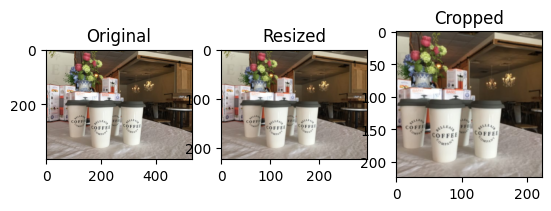

In [6]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(im);
ax[0].set_title('Original');
ax[1].imshow(resized);
ax[1].set_title('Resized');
ax[2].imshow(cropped);
ax[2].set_title('Cropped');

Ahora procesaremos todas las fotos validas del dataset que tienen dimensiones > 224 x 224.

## &#9888; La celda siguiente tarda en completar

In [13]:
%%time
photo_counter = 0

for img in tqdm(range(len(photo_data)), desc='Photos cropped', miniters=500):
    # load image
    im = Image.open('dataset/photos/' + photo_data.iloc[img].photo_id + '.jpg')

    # resize smallest dimension to PHOTO_SIZE
    if (photo_data.iloc[img].y_dim < photo_data.iloc[img].x_dim): # narrow image
        width = int(PHOTO_SIZE)
        height = math.floor(PHOTO_SIZE * photo_data.iloc[img].x_dim/photo_data.iloc[img].y_dim)
    else: # wide image
        width = math.floor(PHOTO_SIZE * photo_data.iloc[img].y_dim/photo_data.iloc[img].x_dim)
        height = int(PHOTO_SIZE)
    
    resized = T.Resize((height, width))(im)
    cropped = T.CenterCrop(size=int(PHOTO_SIZE))(resized)

    # convert to numpy array
    img_np = np.array(cropped)

    if photo_counter % BATCH_SIZE == 0: # save images to file to preserve memory
        if photo_counter > 0:
            pickle.dump(images,
                        open('dataset/processed/images_{}.pkl'.format(photo_counter),
                             'wb'))
            # print('Saved file images_{}.pkl'.format(photo_counter))
        images = [img_np]           # reset image list
    else:
        images += [img_np]          # add image to list
    
    photo_counter += 1
    
pickle.dump(images, open('dataset/processed/images_remainder.pkl','wb'))

Photos cropped:   0%|          | 0/196660 [00:00<?, ?it/s]

Saved file images_20000.pkl
Saved file images_40000.pkl
Saved file images_60000.pkl
Saved file images_80000.pkl
Saved file images_100000.pkl
Saved file images_120000.pkl
Saved file images_140000.pkl
Saved file images_160000.pkl
Saved file images_180000.pkl


In [7]:
file_list = ['dataset/processed/images_{}.pkl'.format(y*BATCH_SIZE) for y in range(1,len(photo_data) //BATCH_SIZE + 1)] + ['dataset/processed/images_remainder.pkl']


## &#9888;&#9888; La celda siguiente requiere 28 GB de memoria y tarda en completar

In [8]:
images = []
for file in tqdm(file_list, desc='Files loaded', miniters=1):
    images += pickle.load(open(file,'rb'))

Files loaded:   0%|          | 0/10 [00:00<?, ?it/s]

La celda siguiente supera los 30 GB (que tengo dedicados al contenedor en que se ejecuta este notebook)

In [ ]:
pickle.dump(images, open('dataset/processed/full_dataset.pkl','wb'))

Este enfoque (brute force) requiere demasiada memória para un único ordenador. En el notebook siguiente probaremos otro enfoque.